# Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

import torch
import torch.nn.functional as F
from torch import nn, Tensor

# Importing our existing flow funcs
import os
import sys
from pathlib import Path
# Add parent directory to sys.path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
# Import modules
#from analytic_flow_funcs import forward_euler_integration_analytic

# Distribution Generation

We generate and visualize our input and output distributions that we want to flow from.

For the analytical solution derived above, the input distribution must always be an n-dimensional independent Gaussian, but our output can be arbitrary.

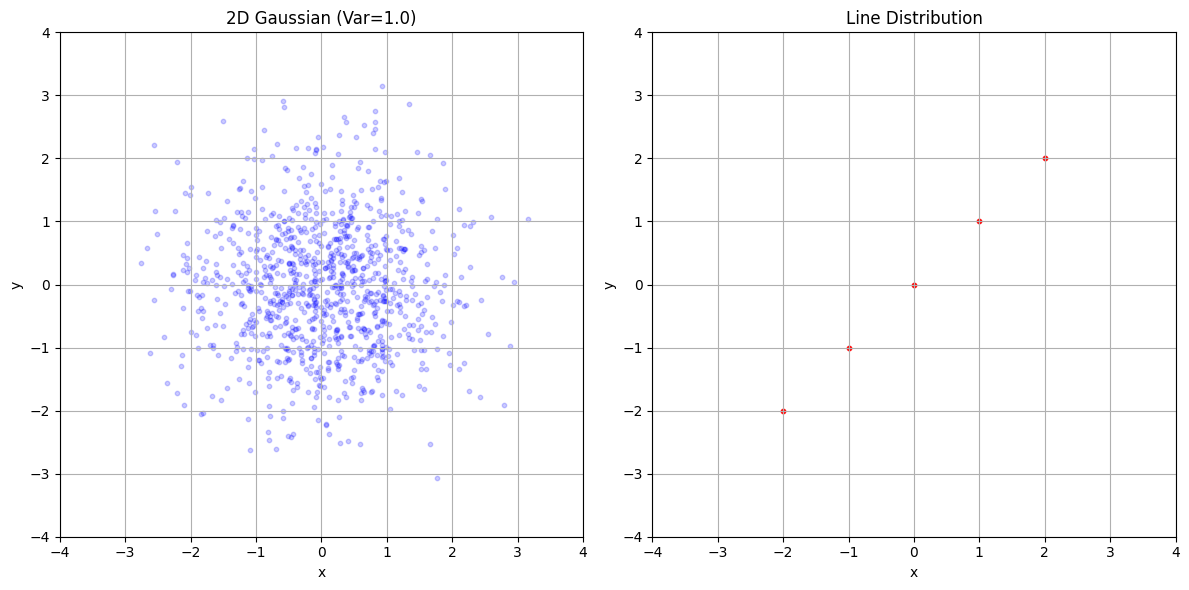

torch.Size([5, 2])


In [4]:
def generate_gaussian(n_dims, num_points, noise_std=1.0):
    """
    Generate an n-dimensional independent Gaussian distribution with specified variance.
    """
    return torch.randn(num_points, n_dims) * (noise_std)

def generate_diagonal_points(num_points=10, upper = 2, lower = -2):
    # Create equally spaced points along the diagonal
    t = torch.linspace(lower, upper, num_points)
    x = t
    y = t
    return torch.stack([x, y], dim=1)
    
# Generate samples with different variances
sigma_i = 1.0
sigma_f = 0.05
num_points = 1000
gaussian_samples1 = generate_gaussian(n_dims=2, num_points=num_points, noise_std=sigma_i)  # Default variance
diagonal_samples = generate_diagonal_points(num_points=5, upper = 2, lower = -2)

# Initial and final distributions
initial_dist = gaussian_samples1
final_dist = diagonal_samples

x_lim_params = (-4, 4)
y_lim_params = (-4, 4)

# Plot the distributions
plt.figure(figsize=(12, 6))

# Plot Gaussian distribution with variance=1.0
plt.subplot(1, 2, 1)
plt.scatter(initial_dist[:, 0].numpy(), initial_dist[:, 1].numpy(), 
            c='blue', alpha=0.2, s=10)
plt.title('2D Gaussian (Var=1.0)')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(x_lim_params)  
plt.ylim(y_lim_params)  
plt.grid(True)

# Plot Spiral distribution
plt.subplot(1, 2, 2)
plt.scatter(final_dist[:, 0].numpy(), final_dist[:, 1].numpy(), 
            c='red', alpha=0.9, s=10)
plt.title('Line Distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(x_lim_params)  
plt.ylim(y_lim_params)  
plt.grid(True)

plt.tight_layout()
plt.show()

print (final_dist.shape)

In [38]:
# Functions to test
def compute_velocity_batch(
    current_points,           # Target points (x), shape (m, n_dims)
    data,                     # Data points (μ_j), shape (n_points, n_dims)
    sigma_i,                  # Initial variance (scalar)
    sigma_f,                  # Final variance (scalar)
    alpha,                    # Shape [M] (batch of alpha values)
    beta,                     # Shape [M] (batch of alpha values)
    alpha_prime,              # dα/dt Shape [M]
    beta_prime,               # dβ/dt Shape [M]
    coefficients=None         # Optional coefficients (C_j), shape (n_points,)
):
    """
    Computes velocity for batched inputs with time as tensor.  
    Allows for arbitrary scheduling
    Returns: velocities: [M, *dims] computed velocities
    """
    # Reshaping time values for broadcasting
    # We need to multiply the final vector which requires [M, *dims]
    alpha_r = alpha.view(-1, *([1]*(data.dim() - 1)))              # [M, *dims]
    alpha_prime_r = alpha_prime.view(-1, *([1]*(data.dim() - 1)))  # [M, *dims]
    beta_r = beta.view(-1, *([1]*(data.dim() - 1)))                # [M, *dims]
    beta_prime_r = beta_prime.view(-1, *([1]*(data.dim() - 1)))    # [M, *dims]

    # We need to multiply the softmax vectors (targets) by time [M, 1, *dims]
    beta_soft_r = beta.view(-1, *([1]*(data.dim())))  # [M, 1, *dims]
    # We need to multiply the vectors after softmax by time [M, 1]
    alpha_post_soft_r = alpha.unsqueeze(-1)           # [M, 1]
    beta_post_soft_r = beta.unsqueeze(-1)             # [M, 1]

    data_exp = data.unsqueeze(0)                    # Reshape data to [1, N, *dims]
    data_scaled = beta_soft_r * data_exp            # [M, 1, *dims] * [1, N, *dims] => [M, N, *dims] 
    current_expanded = current_points.unsqueeze(1)  # [M, 1, *dims]
    
    # Compute distances
    diff = (current_expanded - data_scaled)      # [M, N, *dims]
    squared_dist = torch.sum(diff**2, dim=tuple(range(2, diff.dim())))  # [M, N]

    # Compute softmax weights [M, N]
    denominator = (alpha_post_soft_r**2 * sigma_i) + (beta_post_soft_r**2 * sigma_f)
    logits = -0.5 * squared_dist / denominator
    if coefficients is not None:
        logits = logits + torch.log(coefficients).unsqueeze(0)
    weights = torch.softmax(logits, dim=1)  # [M, N]
    
    # Compute weighted sum [M, *dims]
    weighted_sum = torch.einsum('mn,n...->m...', weights, data)  # [M, *dims]

    # This gives our target vector for each data point.
    # Now, compute velocities
    term1 = current_points * (alpha_prime_r * alpha_r * sigma_i + beta_prime_r * beta_r * sigma_f)
    term2_coeff = alpha_r * sigma_i * (alpha_prime_r * beta_r - alpha_r * beta_prime_r)
    term2 = term2_coeff * weighted_sum

    denominator_vector = (alpha_r**2 * sigma_i) + (beta_r**2 * sigma_f)
    velocity = (term1 - term2) / denominator
    return velocity

def forward_euler_integration_analytic(
    initial_points: torch.Tensor,  # Initial positions [m, *dim]
    data: torch.Tensor,            # Data points [n, *dim]
    t_start: float,                # Start time
    t_end: float,                  # End time
    num_steps: int,                # Number of time steps
    sigma_i: float,                # Initial variance
    sigma_f: float,                # Final variance
    alpha: callable,               # Function alpha(t)
    alpha_prime: callable,         # Derivative of alpha: α'(t)
    beta: callable,                # Function beta(t)
    beta_prime: callable,          # Derivative of beta: β'(t)
    coefficients=None              # Optional coefficients [n]
) -> torch.Tensor:
    """
    Forward Euler integration of the velocity field with general scheduling
    
    Args:
        initial_points: Starting positions [m, *dim]
        data: Fixed data points [n, *dim]
        t_start: Initial time (typically 0)
        t_end: Final time (typically close to 1)
        num_steps: Number of integration steps
        sigma_i: Initial variance parameter
        sigma_f: Final variance parameter
        alpha: Function α(t) for drift scheduling
        alpha_prime: Function α'(t) for drift derivative
        beta: Function β(t) for diffusion scheduling
        beta_prime: Function β'(t) for diffusion derivative
        coefficients: Optional weights for data points
        
    Returns:
        Tensor of shape [num_steps+1, m, *dim] containing the trajectory at each time step
    """
    dt = (t_end - t_start) / num_steps
    trajectory = torch.zeros(num_steps + 1, *initial_points.shape, device=initial_points.device)
    trajectory[0] = initial_points.clone()
    
    current_points = initial_points.clone()
    current_time = torch.full(
        (initial_points.shape[0],), t_start, dtype=initial_points.dtype, device=initial_points.device
    )
    for step in range(1, num_steps + 1):
        # Compute velocity at current position and time
        velocity = compute_velocity_batch(
            current_points=current_points,
            data=data,
            sigma_i=sigma_i,
            sigma_f=sigma_f,
            alpha=alpha(current_time),             # Evaluate α at current time
            beta=beta(current_time),               # Evaluate β at current time
            alpha_prime=alpha_prime(current_time), # Evaluate α' at current time
            beta_prime=beta_prime(current_time),   # Evaluate β' at current time
            coefficients=coefficients
        )
        
        # Forward Euler update
        current_points = current_points + velocity * dt
        current_time = current_time + dt
        
        # Store current positions
        trajectory[step] = current_points.clone()
    
    return trajectory

# Using The Analytical Flow

In [39]:
# Define the scheduling functions and their derivatives
def alpha(t: torch.Tensor) -> torch.Tensor:
    return 1 - t

def alpha_prime(t: torch.Tensor) -> torch.Tensor:
    return torch.full_like(t, -1)

def beta(t: torch.Tensor) -> torch.Tensor:
    return t

def beta_prime(t: torch.Tensor) -> torch.Tensor:
    return torch.ones_like(t)

initial_dist = generate_gaussian(n_dims=2, num_points=4000, noise_std=sigma_i)  # Default variance

# Run integration
start_time = time.time()

# Run the integration
trajectory = forward_euler_integration_analytic(
    initial_points=initial_dist,
    data=final_dist,
    t_start=0.0,
    t_end=1.0,
    num_steps=10,
    sigma_i=sigma_i,
    sigma_f=sigma_f,
    alpha=alpha,          # Pass the alpha function
    alpha_prime=alpha_prime,  # Pass its derivative
    beta=beta,            # Pass the beta function
    beta_prime=beta_prime,    # Pass its derivative
    coefficients=None     # Uniform weights if None
)

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Integration completed in {elapsed_time:.4f} seconds")


Integration completed in 0.0256 seconds


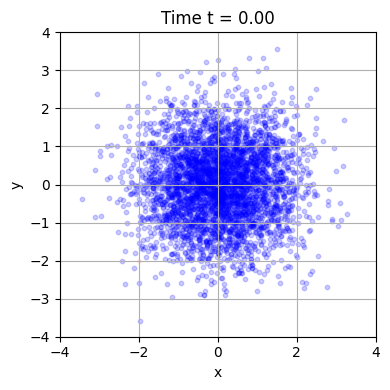

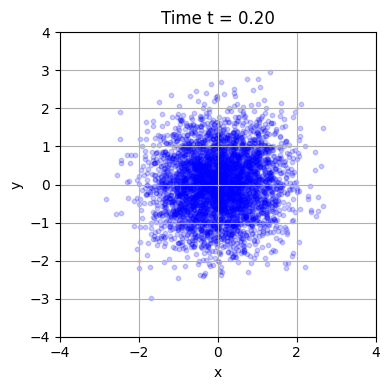

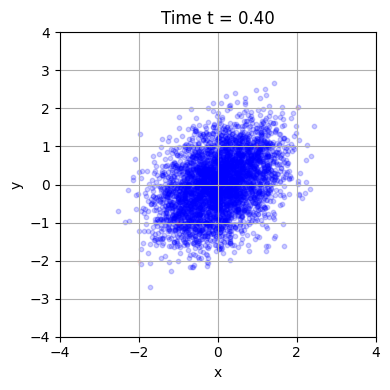

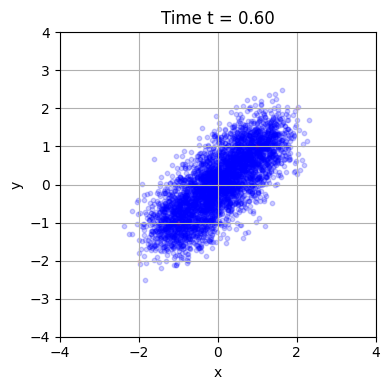

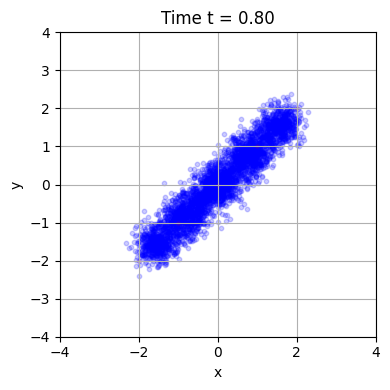

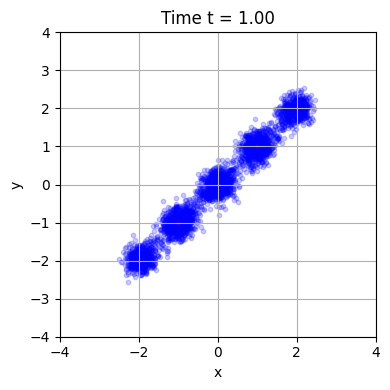

In [40]:
steps_to_plot = [0, 20, 40, 60, 80, 100]

steps_to_plot = [0, 2, 4, 6, 8, 10]
for i, step in enumerate(steps_to_plot):
    current_time = step/max(steps_to_plot)
    current_points = trajectory[step]
    
    plt.figure(figsize=(4, 4))
    plt.scatter(current_points[:, 0].numpy(), current_points[:, 1].numpy(),
               c='blue', alpha=0.2, s=10, label='Current Points')
    plt.scatter(final_dist[:, 0].numpy(), final_dist[:, 1].numpy(),
               c='red', alpha=0.1, s=5, label='Target Distribution')
    
    plt.title(f'Time t = {current_time:.2f}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(x_lim_params)  
    plt.ylim(y_lim_params)  
    plt.grid(True)    
    plt.tight_layout()
    plt.show()

## Animated GIF

In [41]:
def animate_trajectory(trajectory, final_dist):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Initialize scatter plots
    current_scatter = ax.scatter([], [], c='blue', alpha=0.2, s=10, label='Current Points')
    target_scatter = ax.scatter(final_dist[:, 0], final_dist[:, 1], c='red', alpha=1.0, s=15, label='Target Distribution')
    
    ax.set_xlim(x_lim_params)
    ax.set_ylim(y_lim_params)
    ax.grid(True)
    ax.legend(loc='upper right')
    
    def update(frame):
        current_scatter.set_offsets(trajectory[frame])
        ax.set_title(f'Time t = {frame/(len(trajectory)-1):.2f}')
        return current_scatter,
    
    ani = FuncAnimation(fig, update, frames=len(trajectory), interval=50, blit=True)
    plt.close()
    return ani

os.makedirs('imgs', exist_ok=True)

# Create animation and save
start_time = time.time()
ani = animate_trajectory(trajectory.numpy(), final_dist.numpy())
ani.save('imgs/flow_matching_analytic_line.gif', writer='pillow', fps=20, dpi=80)
# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Gif made in {elapsed_time:.4f} seconds")

# To display in Jupyter notebook:
from IPython.display import HTML
HTML(ani.to_jshtml())

Gif made in 1.8991 seconds
